In [9]:
# Tag each problem with tags listed in leetcode but not present in Hackerrank
import pandas as pd
import openai

# Function to fetch tags using OpenAI API
def fetch_tags(description, tags_list):
    try:
        response = openai.Completion.create(
            model="gpt-3.5-turbo-instruct",  # Adjust to the latest available model
            prompt=f"Given the following Java code, identify the top 10 most relevant programming tags from this list: {tags_list}\n\nJava Solution:\n{description}. Provide the response as a comma separated string of tags, with no other explanation.",
            max_tokens=150  # Adjust based on need
        )
        # Assuming the response will be a comma-separated string of tags
        return response.choices[0].text.strip().split(', ')
    except openai.error.OpenAIError as e:
        print(f"An error occurred: {e}")
        return []

# Set your OpenAI API key
# openai.api_key ='sk-proj-in9nUUExROKAQE9p5HxZT3BlbkFJtg32jFMGzDJIejvSYMvP'

# Tags from the image
tags_list = [
    "Array", "String", "Hash Table", "Math", "Dynamic Programming", "Sorting", "Greedy",
    "Depth-First Search", "Database", "Binary Search", "Breadth-First Search", "Tree", "Matrix",
    "Bit Manipulation", "Two Pointers", "Binary Tree", "Heap (Priority Queue)", "Prefix Sum",
    "Stack", "Simulation", "Graph", "Design", "Counting", "Sliding Window", "Backtracking",
    "Union Find", "Enumeration", "Linked List", "Ordered Set", "Monotonic Stack", "Trie",
    "Number Theory", "Divide and Conquer", "Recursion", "Bitmask", "Queue", "Binary Search Tree",
    "Segment Tree", "Memoization", "Geometry", "Hash Function", "Binary Indexed Tree",
    "Topological Sort", "String Matching", "Combinatorics", "Rolling Hash", "Shortest Path",
    "Game Theory", "Interactive", "Data Stream", "Brainteaser", "Monotonic Queue", "Randomized",
    "Merge Sort", "Iterator", "Concurrency", "Doubly-Linked List", "Probability and Statistics",
    "Quicksort", "Bucket Sort", "Suffix Array", "Minimum Spanning Tree", "Counting Sort", "Shell",
    "Line Sweep", "Reservoir Sampling", "Strongly Connected Component", "Eulerian Circuit",
    "Radix Sort", "Rejection Sampling", "Biconnected Component"
]

# Load the CSV file
def load_and_tag_csv(filepath):
    df = pd.read_csv(filepath)
    df['Tags'] = df['GROUND'].apply(lambda x: fetch_tags(x, tags_list))
    return df

# Save the DataFrame with tags back to CSV
def save_csv(df, filepath):
    df.to_csv(filepath, index=False)

# Main function to process the CSV file
def process_csv(input_filepath, output_filepath):
    df = load_and_tag_csv(input_filepath)
    save_csv(df, output_filepath)

# Replace 'input.csv' and 'output_with_tags.csv' with your file paths.
process_csv('final_merged.csv', 'final_merged_with_tags.csv')

An error occurred: This model's maximum context length is 4097 tokens, however you requested 6430 tokens (6280 in your prompt; 150 for the completion). Please reduce your prompt; or completion length.
An error occurred: This model's maximum context length is 4097 tokens, however you requested 5513 tokens (5363 in your prompt; 150 for the completion). Please reduce your prompt; or completion length.
An error occurred: This model's maximum context length is 4097 tokens, however you requested 8421 tokens (8271 in your prompt; 150 for the completion). Please reduce your prompt; or completion length.
An error occurred: This model's maximum context length is 4097 tokens, however you requested 4515 tokens (4365 in your prompt; 150 for the completion). Please reduce your prompt; or completion length.


In [10]:
# Generate the one-shot and few-shot prompts. 
# Few shot prompts examples are added by intersecting the tags of the current problem with the tags of all the other problems and adding 
# the example with the most intersections.
import pandas as pd
import openai

# Set your OpenAI API key
# openai.api_key='sk-proj-in9nUUExROKAQE9p5HxZT3BlbkFJtg32jFMGzDJIejvSYMvP'

def string_to_list(tag_string):
    # Handle None values and empty strings
    if not tag_string or pd.isna(tag_string):
        return []
    # Split the string on comma and strip whitespace from each tag
    return [tag.strip() for tag in tag_string.split(',')]

def fetch_response(prompt):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that provides the most optimized Java code solutions."},
                {"role": "user", "content": prompt}
            ]
        )
        # Assuming the code output is the content of the last message from the assistant
        return response['choices'][0]['message']['content']
    except Exception as e:  # General exception handling, consider logging or more specific exception handling
        print(f"An error occurred: {e}")
        return "ERROR: Could not generate a response"

def split_and_find_matches(df):
    # Convert the string of tags into a list
    df['Tags'] = df['Tags'].apply(string_to_list)

    def count_matching_tags(tags1, tags2):
        set1 = set(tags1)
        set2 = set(tags2)
        return len(set1.intersection(set2))

    results = []

    for index, row in df.iterrows():
        # Calculate matching tags with all other rows
        df['MatchingTags'] = df['Tags'].apply(lambda x: count_matching_tags(x, row['Tags']))
        # Find the row with the maximum number of matching tags
        max_matching_index = df['MatchingTags'].idxmax()
        best_match = df.iloc[max_matching_index]

        # Construct few-shot and one-shot prompts
        prompt_fewshot = (
            f"This is a code block, written in Java, that has a slow algorithmic time complexity: {row['GROUND']}\n\n"
            f"I want you to optimize the code above such that the new code is more time efficient "
            f"and serves the same objective as the code block above. I don't want you to give me "
            f"any explanation, just return the newly generated code.\n"
            f"Use a similar optimization example as a reference. \nExample - The code: {best_match['GROUND']}\n"
            f"is optimized to: {best_match['BEST']}"
        )

        prompt_oneshot = (
            f"This is a code block, written in Java, that has a slow algorithmic time complexity: {row['GROUND']}\n\n"
            f"I want you to optimize the code above such that the new code is more time efficient "
            f"and serves the same objective as the code block above. I don't want you to give me "
            f"any explanation, just return the newly generated code."
        )
        
        few_shot_response = fetch_response(prompt_fewshot)

        results.append({
            'One Shot Prompt': prompt_oneshot,
            'Few Shot Prompt': prompt_fewshot,
            'Few Shot Response': few_shot_response
        })

    # Create a DataFrame with the results
    prompts_df = pd.DataFrame(results)
    final_df = pd.concat([df.reset_index(drop=True), prompts_df], axis=1)

    return final_df

# Load the data
df = pd.read_csv('final_merged_with_tags.csv')

# Generate the DataFrame with prompts
test_df_with_prompts = split_and_find_matches(df)

# Save to CSV
output_csv_path = 'final_merged_with_prompts.csv'
test_df_with_prompts.to_csv(output_csv_path, index=False)

An error occurred: This model's maximum context length is 16385 tokens. However, your messages resulted in 17788 tokens. Please reduce the length of the messages.
An error occurred: This model's maximum context length is 16385 tokens. However, your messages resulted in 16871 tokens. Please reduce the length of the messages.
An error occurred: This model's maximum context length is 16385 tokens. However, your messages resulted in 19779 tokens. Please reduce the length of the messages.


In [12]:
# Make the LLM generate test cases for the best and few shot java code results, compare the actual run time, and produce the comparison 
# result as BEST or FEW-SHOT
def fetch_response(best_code, few_shot_code):
    try:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant that compares Java code solutions by generating a test case that can be used by both solutions, tracking the time it takes to run each of the solutions with the test case and then giving one response: BEST or FEW-SHOT stating which performs better."},
                 {"role": "user", "content": f"Compare the following two Java solutions and determine which one performs better. Solution 1 (BEST): {best_code} Solution 2 (FEW-SHOT): {few_shot_code}. Only give me the result: Whether it is FEW-SHOT or BEST, I want no other explanation."}
            ]
        )
        # Assuming the code output is the content of the last message from the assistant
        return response['choices'][0]['message']['content']
    except Exception as e:  # General exception handling, consider logging or more specific exception handling
        print(f"An error occurred: {e}")
        return "ERROR: Could not generate a response"
        
def compare_execution_times(df):
    for index, row in df.iterrows():
        # Send the BEST and Few Shot Response code to OpenAI for comparison
        comparison_result = fetch_response(row['BEST'], row['Few Shot Response'])
        # Store the result in a new column
        df.at[index, 'Comparison Result'] = comparison_result
    return df

def process_csv(file_path):
    df = pd.read_csv(file_path)
    updated_df = compare_execution_times(df)
    updated_file_path = 'updated_' + file_path
    updated_df.to_csv(updated_file_path, index=False)
    return updated_file_path

# Run the process on your CSV file
process_csv('final_merged_with_prompts.csv')

'updated_final_merged_with_prompts.csv'

In [13]:
import pandas as pd

def analyze_results(file_path):
    df = pd.read_csv(file_path)
    # Check for NaN values and fill them with an empty string to avoid counting errors
    df['Comparison Result'] = df['Comparison Result'].fillna('')
    
    # Count the occurrences of each comparison result
    result_counts = df['Comparison Result'].value_counts()
    
    # Extract the number of 'BEST' and 'FEW-SHOT' results
    best_count = result_counts.get('BEST', 0)
    few_shot_count = result_counts.get('FEW-SHOT', 0)

    return best_count, few_shot_count

# Run the analysis on your updated CSV file
file_path = 'updated_final_merged_with_prompts.csv'
best_count, few_shot_count = analyze_results(file_path)

print(f"Number of 'BEST' results: {best_count}")
print(f"Number of 'FEW-SHOT' results: {few_shot_count}")

Number of 'BEST' results: 47
Number of 'FEW-SHOT' results: 3


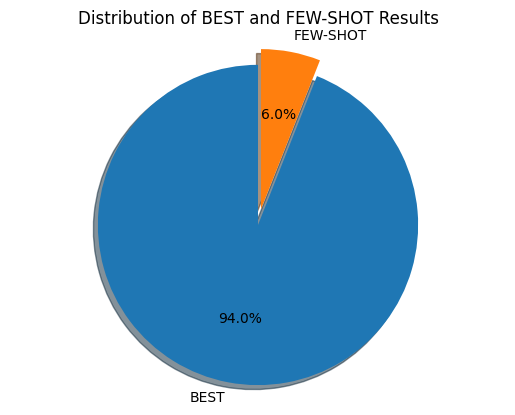

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_results(file_path):
    df = pd.read_csv(file_path)
    df['Comparison Result'] = df['Comparison Result'].fillna('')

    # Count the occurrences of each comparison result
    result_counts = df['Comparison Result'].value_counts()

    return result_counts

def create_pie_chart(result_counts):
    # Prepare data for the pie chart
    labels = result_counts.index
    sizes = result_counts.values
    explode = [0.1 if label == 'BEST' else 0 for label in labels]  # 'explode' the BEST slice if present

    # Plotting the pie chart
    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Title for the pie chart
    plt.title('Distribution of BEST and FEW-SHOT Results')

    # Show the pie chart
    plt.show()

# Run the analysis on your updated CSV file
file_path = 'updated_final_merged_with_prompts.csv'
result_counts = analyze_results(file_path)

# Create and display the pie chart
create_pie_chart(result_counts)